In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
counts = sc.read_mtx('data/gene_sorted-matrix.mtx').T
barcodes = pd.read_csv('data/barcodes.tsv', header=None, sep='\t')
genes = pd.read_csv('data/genes.tsv', header=None, sep='\t')

In [3]:
counts.obs_names = barcodes[0].values
counts.var_names = genes[0].values

print(counts.shape)
print(barcodes.shape)
print(genes.shape)

(98047, 19712)
(98047, 1)
(19712, 2)


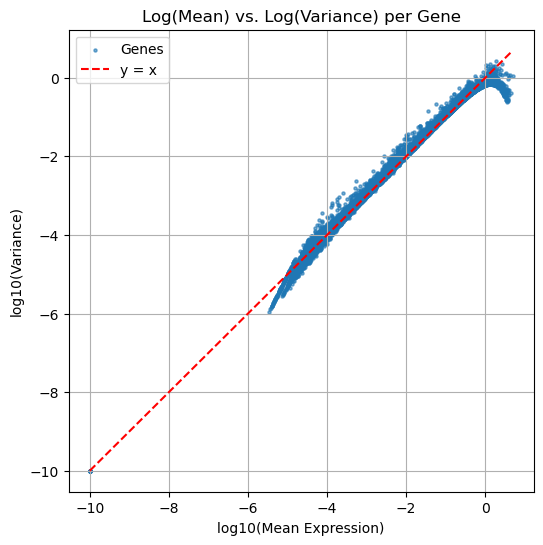

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Convert sparse matrix to dense (if needed)
dense_counts = counts.X.toarray() if not isinstance(counts.X, np.ndarray) else counts.X

# Calculate mean and variance across cells for each gene
gene_means = dense_counts.mean(axis=0)
gene_vars = dense_counts.var(axis=0)

# Log-transform
log_means = np.log10(gene_means + 1e-10)
log_vars = np.log10(gene_vars + 1e-10)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(log_means, log_vars, s=5, alpha=0.6, label='Genes')

# Add y = x reference line
min_val = min(log_means.min(), log_vars.min())
max_val = max(log_means.max(), log_vars.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')

plt.xlabel("log10(Mean Expression)")
plt.ylabel("log10(Variance)")
plt.title("Log(Mean) vs. Log(Variance) per Gene")
plt.legend()
plt.grid(True)
plt.show()


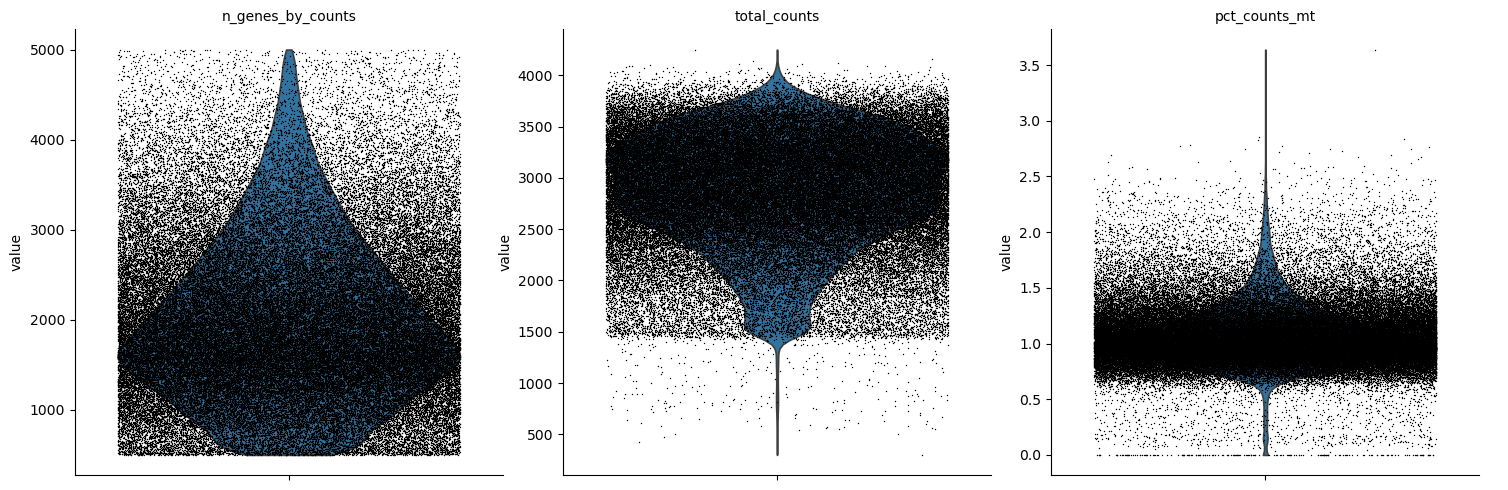

In [5]:
# Mark mitochondrial genes (mouse: usually "mt-")
counts.var["mt"] = counts.var_names.str.startswith(("mt-", "MT-"))

# Ribosomal genes (same as tutorial)
counts.var["ribo"] = counts.var_names.str.startswith(("Rps", "Rpl", "RPS", "RPL"))

# Hemoglobin genes (depends on species, may not be as relevant in all mouse tissues)
counts.var["hb"] = counts.var_names.str.contains("^Hb[^(p)]", case=False)

# Calculate QC metrics
sc.pp.calculate_qc_metrics(
    counts, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

# Plot QC violin plots
sc.pl.violin(
    counts,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

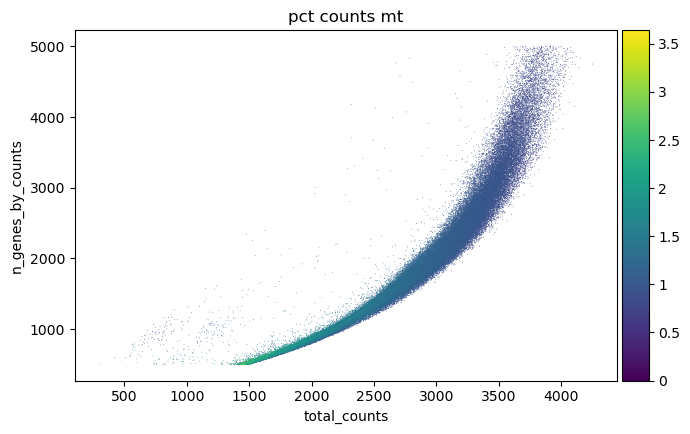

In [6]:
sc.pl.scatter(counts, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [7]:
sc.pp.filter_cells(counts, min_genes=100)
sc.pp.filter_genes(counts, min_cells=3)

In [8]:
# Saving count data
counts.layers["counts"] = counts.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(counts)
# Logarithmize the data
sc.pp.log1p(counts)

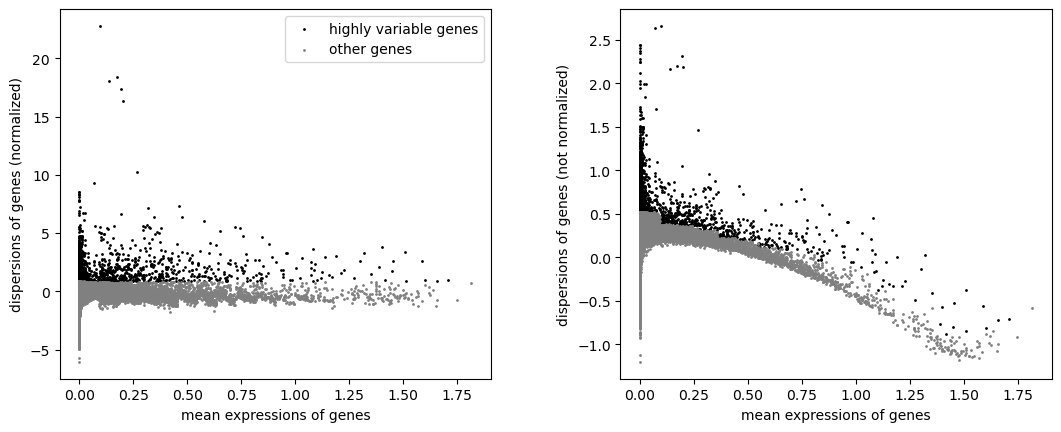

In [9]:
sc.pp.highly_variable_genes(counts, n_top_genes=2000)
sc.pl.highly_variable_genes(counts)

In [10]:
sc.tl.pca(counts)

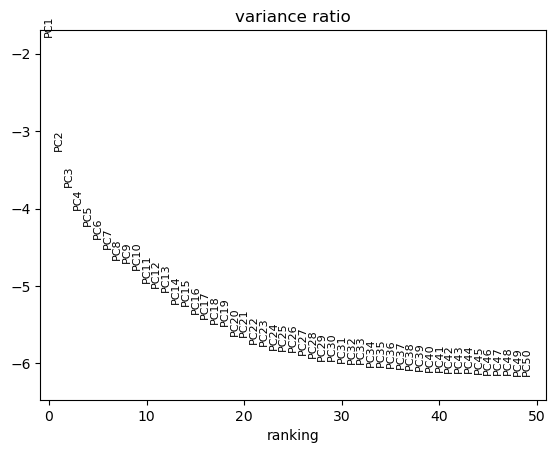

In [11]:
sc.pl.pca_variance_ratio(counts, n_pcs=50, log=True)

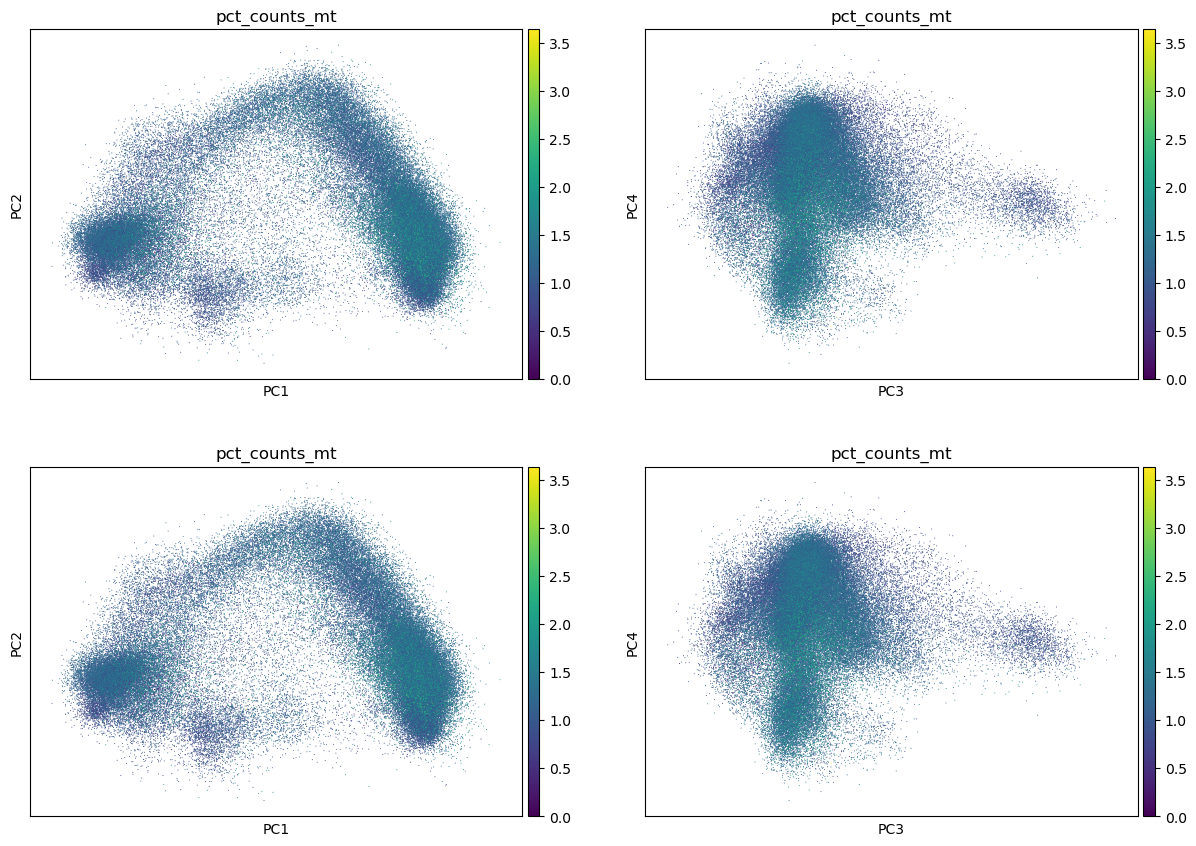

In [12]:
sc.pl.pca(
    counts,
    color=["pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

In [13]:
sc.pp.neighbors(counts)

/home/logan/anaconda3/envs/nn_project_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
sc.tl.umap(counts)

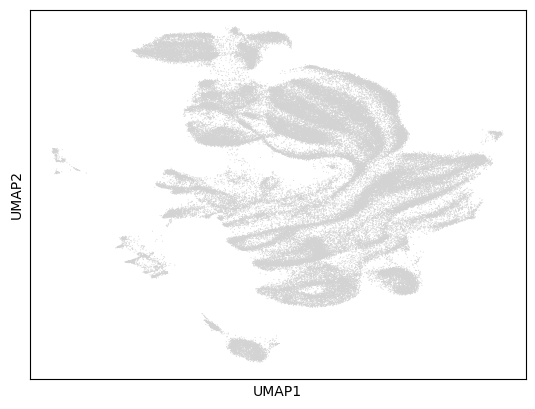

In [15]:
sc.pl.umap(
    counts,
    # Setting a smaller point size to get prevent overlap
    size=2,
)

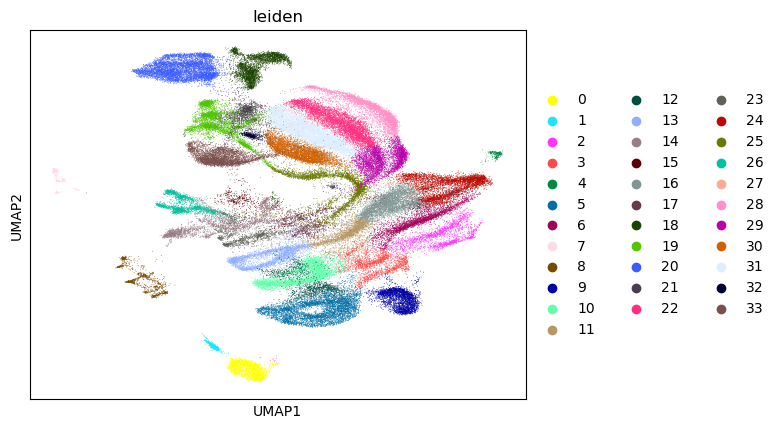

In [16]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(counts, flavor="igraph", n_iterations=2)
sc.pl.umap(counts, color=["leiden"])

KeyError: 'Could not find key predicted_doublet in .var_names or .obs.columns.'

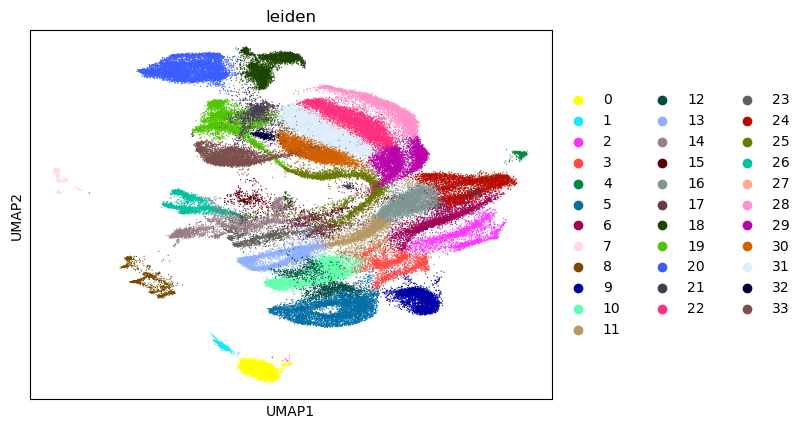

In [17]:
sc.pl.umap(
    counts,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

In [ ]:
sc.pl.umap(
    counts,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)